In [1]:
import pandas as pd
import numpy as np
import liwc
import re
import emoji
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer
from collections import Counter
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data and dictionaries
df = pd.read_csv ('data/tweets/IchBinHanna.csv')
german_parse, german_categories = liwc.load_token_parser('data/dicts/LIWC2007_German.dic')
english_parse, english_categories = liwc.load_token_parser('data/dicts/LIWC2015_English.dic')

In [3]:
#prepare data, drop retweets and split it into german and english tweets
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df = df[df['text'].str.contains("#ichbinhanna", case = False)]
df['processed'] = df['text'].replace(r'\\n',  ' ', regex=True)
df['processed'] = df['processed'].apply(lambda x:  re.sub(r'[0-9]+', '', x))
df['processed'] = df['processed'].apply(rem_url)
#remove emojis (as seen here: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['processed'].astype(str)
#tokenize tweets
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
#remove stopwords
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in (german_stop)]).split(),axis=1)
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "innen", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 1])
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_ger['categories'] = df_ger['tokenized'].apply(lambda x: Counter(category for token in x for category in german_parse(token)))
df_en['categories'] = df_en['tokenized'].apply(lambda x: Counter(category for token in x for category in english_parse(token)))

In [5]:
#function to get relative scores of each category
def get_relative(cats, tokens):
    out = {}
    for k in cats:
        out[k] = round(cats[k]/len(tokens),4)
    return out

In [6]:
#convert counter to dict
df_en['categories'] = df_en['categories'].apply(lambda x: dict(x))
df_ger['categories'] = df_ger['categories'].apply(lambda x: dict(x))
#get percentage of classes
df_en['categories'] = [get_relative(x, y) for x, y in zip(df_en['categories'], df_en['tokenized'])]
df_ger['categories'] = [get_relative(x, y) for x, y in zip(df_ger['categories'], df_ger['tokenized'])]

In [7]:
#only keep sentiment information from category-list and align category names from the different dictionarys (Posfeel from the german dictionary is excluded, as all words from this category are also Posemo)
cat_list = ['Posemo', 'Negemo', 'Anx', 'Sad', 'Anger',  'posemo (Positive Emotions)', 'negemo (Negative Emotions)', 'anx (Anx)', 'sad (Sad)', 'anger (Anger)']
def keep_cats(cats):
    out={}
    for k in cats:
        if k in cat_list:
            if k == 'posemo (Positive Emotions)':
                out['Posemo'] = cats[k]
            elif k == 'negemo (Negative Emotions)':
                out['Negemo'] = cats[k]
            elif k == 'anx (Anx)':
                out['Anx'] = cats[k]
            elif k == 'sad (Sad)':
                out['Sad'] = cats[k]
            elif k == 'anger (Anger)':
                out['Anger'] = cats[k]
            else:
                out[k] = cats[k]
    return out

In [8]:
df_en['categories'] = [keep_cats(x) for x in df_en['categories']]
df_ger['categories'] = [keep_cats(x) for x in df_ger['categories']]

In [9]:
#create new columns for each score
df_en[['Posemo', 'Negemo','Anx','Anger', 'Sad']] = df_en['categories'].apply(pd.Series)
df_ger[['Posemo', 'Negemo','Anx','Sad', 'Anger']] = df_ger['categories'].apply(pd.Series)

In [10]:
#make index for the new columns coherent
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df
df_en = df_column_switch(df_en, 'Sad', 'Anger')

In [11]:
#rejoin data frame, then fill sentiment values with NaN with zeros
df_sentiment = pd.concat([df_en,df_ger])
df_sentiment['Posemo'] = df_sentiment['Posemo'].fillna(0.0)
df_sentiment['Negemo'] = df_sentiment['Negemo'].fillna(0.0)
df_sentiment['Anger'] = df_sentiment['Anger'].fillna(0.0)
df_sentiment['Sad'] = df_sentiment['Sad'].fillna(0.0)
df_sentiment['Anx'] = df_sentiment['Anx'].fillna(0.0)

In [12]:
df_sentiment['Sentiment Score'] = df_sentiment['Posemo'] - df_sentiment['Negemo']

In [13]:
conditions = [(df_sentiment['Sentiment Score'] < 0), (df_sentiment['Sentiment Score'] == 0),(df_sentiment['Sentiment Score'] > 0)]
values = ['negative', 'neutral', 'positive']
df_sentiment['sentiment'] = np.select(conditions, values)
print(df_sentiment['sentiment'].value_counts())

neutral     8786
positive    7638
negative    3512
Name: sentiment, dtype: int64


In [14]:
df_sentiment_de = df_sentiment.loc[df_sentiment['lang']=='de']
df_sentiment_en = df_sentiment.loc[df_sentiment['lang'] == 'en']

In [15]:
#some descriptive statistics
print("Max and Min Sentiment scores:\n Max:{0}\n Min:{1}".format(df_sentiment['Sentiment Score'].max(), df_sentiment['Sentiment Score'].min()))
print("Mean Sentiment score:\n {0}".format(round(df_sentiment['Sentiment Score'].mean(),4)))
print(df_sentiment_de['sentiment'].value_counts())
print(df_sentiment_de['sentiment'].value_counts(normalize=True))
print(df_sentiment_en['sentiment'].value_counts())
print(df_sentiment_en['sentiment'].value_counts(normalize =True))

Max and Min Sentiment scores:
 Max:1.0
 Min:-1.0
Mean Sentiment score:
 0.0262
neutral     7688
positive    6597
negative    3029
Name: sentiment, dtype: int64
neutral     0.444034
positive    0.381021
negative    0.174945
Name: sentiment, dtype: float64
neutral     1098
positive    1041
negative     483
Name: sentiment, dtype: int64
neutral     0.418764
positive    0.397025
negative    0.184211
Name: sentiment, dtype: float64


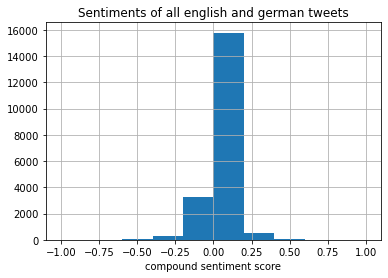

In [16]:
#distribution of overall sentiment scores
df_sentiment['Sentiment Score'].hist()
plt.title('Sentiments of all english and german tweets')
plt.xlabel('compound sentiment score')
plt.show()

In [17]:
df_day = df_sentiment[['new_date', 'Sentiment Score']]
#compute mean scores over days
df_day = df_day.groupby([pd.to_datetime(df_day['new_date']).dt.date]).mean()
df_day = df_day.reset_index()

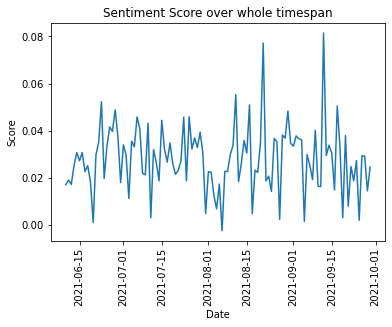

In [18]:
plt.plot(df_day['new_date'],df_day['Sentiment Score'])
plt.title('Sentiment Score over whole timespan')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

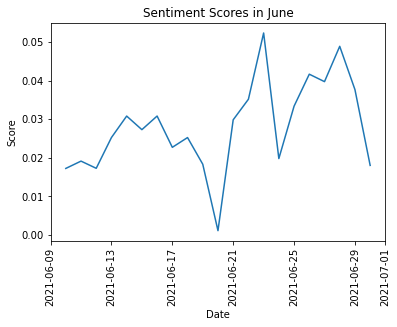

In [19]:
#for a better overview, split the data into months
df_june = df_day.loc[df_day['new_date'] < pd.to_datetime('2021-07-01')]
plt.plot(df_june['new_date'],df_june['Sentiment Score'])
plt.title('Sentiment Scores in June')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

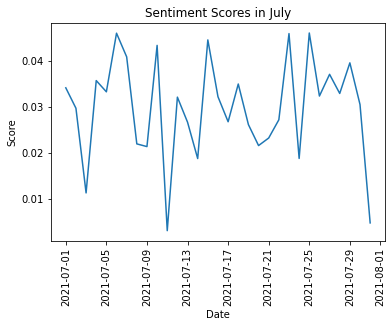

In [20]:
df_july = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_day['new_date'] < pd.to_datetime('2021-08-01'))]
plt.plot(df_july['new_date'],df_july['Sentiment Score'])
plt.title('Sentiment Scores in July')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

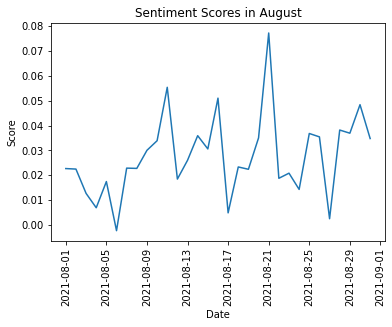

In [21]:
df_august = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_day['new_date'] < pd.to_datetime('2021-09-01'))]
plt.plot(df_august['new_date'],df_august['Sentiment Score'])
plt.title('Sentiment Scores in August')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

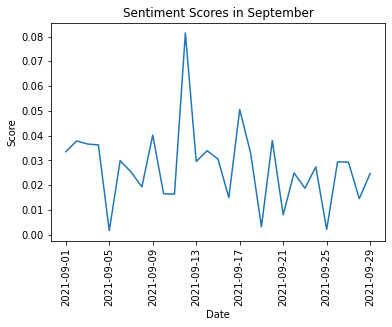

In [22]:
df_september = df_day.loc[(df_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_day['new_date'] < pd.to_datetime('2021-10-01'))]
plt.plot(df_september['new_date'],df_september['Sentiment Score'])
plt.title('Sentiment Scores in September')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.show()

In [23]:
pos_LIWC = df_sentiment.loc[df_sentiment['sentiment'] == 'positive']
neg_LIWC = df_sentiment.loc[df_sentiment['sentiment'] == 'negative']
pos_LIWC = pos_LIWC['text']
neg_LIWC = neg_LIWC['text']

In [24]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='pos_LIWC.csv')  
pos_LIWC.to_csv('out.zip', index=False,
          compression=compression_opts) 

In [25]:
#for further investigation
compression_opts = dict(method='zip',
                        archive_name='neg_LIWC.csv')  
neg_LIWC.to_csv('out.zip', index=False,
          compression=compression_opts) 

## Agreement of LIWC and VADER

In [26]:
vader_sentiment = pd.read_csv ('data/tweets/vader_sentiment.csv', index_col=0)

In [27]:
print(len(vader_sentiment))
print(len(df_sentiment))

19936
19936


In [28]:
vader_sentiment

,__twarc.retrieved_at,__twarc.url,__twarc.version,attachments.media,attachments.media_keys,attachments.poll.duration_minutes,attachments.poll.end_datetime,attachments.poll.id,attachments.poll.options,attachments.poll.voting_status,...,wanted_tag,new_date,processed,neg,neu,pos,compound,sentiment,hashtags separated,tokenized
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-26 21:40:18,"Summer break. Pause, leisure, relaxation. Mayb...",0.131,0.712,0.157,0.2235,positive,"[""'IchbinHanna'""]","['summer', 'break', 'pause', 'leisure', 'relax..."
3,2021-07-27T13:10:02+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-26 21:40:23,Hanna will be just another number in the acade...,0.000,0.776,0.224,0.8176,positive,"[""'WirsindHanna'"", "" 'IchbinHanna'""]","['another', 'number', 'academic', 'records', '..."
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-26 18:44:06,In th middle of #IchbinHanna debates in German...,0.000,1.000,0.000,0.0000,neutral,"[""'IchbinHanna'"", "" 'SchrödingerPostdoc'"", "" '...","['th', 'middle', 'debates', 'germany', 'amreib..."
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-26 09:03:27,"With some delay, here is an English version of...",0.119,0.881,0.000,-0.3182,negative,"[""'IchBinHanna'"", "" 'Ichbinreyhan'""]","['delay', 'english', 'version', 'amreibahr', '..."
85,2021-07-27T13:10:02+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-26 16:05:49,#IchbinHanna - with a view on recent US HEI fa...,0.000,1.000,0.000,0.0000,neutral,"[""'IchbinHanna'""]","['view', 'recent', 'us', 'hei', 'faculty', 'em..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116906,2021-10-01T06:52:58+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-27 06:48:08,15 € netto die Stunde. Respekt. #IchBinHannah,0.000,0.625,0.375,0.4588,positive,"[""'IchBinHannah'""]","['elisabethbhm', '15', 'netto', 'stunde', 'res..."
116909,2021-10-01T06:52:58+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-27 06:42:22,Professorin zu #IchBinHanna : „Alle sind ausge...,0.000,1.000,0.000,0.0000,neutral,"[""'IchBinHanna'""]","['professorin', 'ausgebrannt', 'deprimiert']"
116919,2021-10-01T06:52:58+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-27 06:09:05,#StopThecuts #IchbinHanna #onlineLehre #online...,0.000,0.797,0.203,0.4215,positive,"[""'StopThecuts'"", "" 'IchbinHanna'"", "" 'onlineL...","['schaut', 'blogbeiträge', 'rein']"
116924,2021-10-01T06:52:58+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,2021-07-27 04:16:11,Ihr armen Hannas. Im 1.Semester hat man euch g...,0.154,0.846,0.000,-0.7256,negative,"[""'IchbinHanna'""]","['armen', 'hannas', 'semester', 'gesagt', 'uni..."


In [29]:
vader_sent = vader_sentiment['sentiment']
df_sentiment['vader sentiment'] = vader_sent
total_agreement = np.where(df_sentiment['sentiment'] == df_sentiment['vader sentiment'])
df_pos_ag = df_sentiment.loc[df_sentiment['sentiment'] == 'positive']
positive_agreement = np.where(df_pos_ag['sentiment'] == df_pos_ag['vader sentiment'])
df_neg_ag = df_sentiment.loc[df_sentiment['sentiment'] == 'negative']
negative_agreement = np.where(df_neg_ag['sentiment'] == df_neg_ag['vader sentiment'])
df_neu_ag = df_sentiment.loc[df_sentiment['sentiment'] == 'neutral']
neutral_agreement = np.where(df_neu_ag['sentiment'] == df_neu_ag['vader sentiment'])

In [30]:
print('Total agreement: {0} \nRelative: {1}'.format(len(total_agreement[0]), len(total_agreement[0])/len(df_sentiment)))
print('Positive agreement: {0} \nRelative: {1}'.format(len(positive_agreement[0]), len(positive_agreement[0])/len(df_pos_ag)))
print('Negative agreement: {0} \nRelative: {1}'.format(len(negative_agreement[0]), len(negative_agreement[0])/len(df_neg_ag)))
print('Neutral agreement: {0} \nRelative: {1}'.format(len(neutral_agreement[0]), len(neutral_agreement[0])/len(df_neu_ag)))

Total agreement: 11387 
Relative: 0.5711777688603531
Positive agreement: 6192 
Relative: 0.8106834249803614
Negative agreement: 1954 
Relative: 0.556378132118451
Neutral agreement: 3241 
Relative: 0.3688823127703164


In [31]:
#change threshold for neutral tweets to -0.1 - 0.1 (for LIWC)
conditions = [(df_sentiment['Sentiment Score'] <= -0.1), (-0.1 < df_sentiment['Sentiment Score'])&(df_sentiment['Sentiment Score'] < 0.1),(df_sentiment['Sentiment Score'] >= 0.1)]
values = ['negative', 'neutral', 'positive']
df_sentiment['thresholded sentiment'] = np.select(conditions, values)
print(df_sentiment['thresholded sentiment'].value_counts())
total_agreement = np.where(df_sentiment['thresholded sentiment'] == df_sentiment['vader sentiment'])
df_pos_ag = df_sentiment.loc[df_sentiment['thresholded sentiment'] == 'positive']
positive_agreement = np.where(df_pos_ag['thresholded sentiment'] == df_pos_ag['vader sentiment'])
df_neg_ag = df_sentiment.loc[df_sentiment['thresholded sentiment'] == 'negative']
negative_agreement = np.where(df_neg_ag['thresholded sentiment'] == df_neg_ag['vader sentiment'])
df_neu_ag = df_sentiment.loc[df_sentiment['thresholded sentiment'] == 'neutral']
neutral_agreement = np.where(df_neu_ag['thresholded sentiment'] == df_neu_ag['vader sentiment'])
print('Total agreement: {0} \nRelative: {1}'.format(len(total_agreement[0]), len(total_agreement[0])/len(df_sentiment)))
print('Positive agreement: {0} \nRelative: {1}'.format(len(positive_agreement[0]), len(positive_agreement[0])/len(df_pos_ag)))
print('Negative agreement: {0} \nRelative: {1}'.format(len(negative_agreement[0]), len(negative_agreement[0])/len(df_neg_ag)))
print('Neutral agreement: {0} \nRelative: {1}'.format(len(neutral_agreement[0]), len(neutral_agreement[0])/len(df_neu_ag)))

neutral     15186
positive     3469
negative     1281
Name: thresholded sentiment, dtype: int64
Total agreement: 7543 
Relative: 0.3783607544141252
Positive agreement: 2941 
Relative: 0.847794753531277
Negative agreement: 806 
Relative: 0.6291959406713505
Neutral agreement: 3796 
Relative: 0.24996707493744239
